图像语义分割：对图像 **每一个点/像素** 进行分类！不同种类用不同颜色区分开。

区分与实例分割的不同：实例分割同一物种（比如有多只羊），不同只之间也要划分开来！即对每个像素划分完大类后，再划分小类。

---

语义分割到底干了什么：右边就是目标数据！自己做目标时也要这么做！

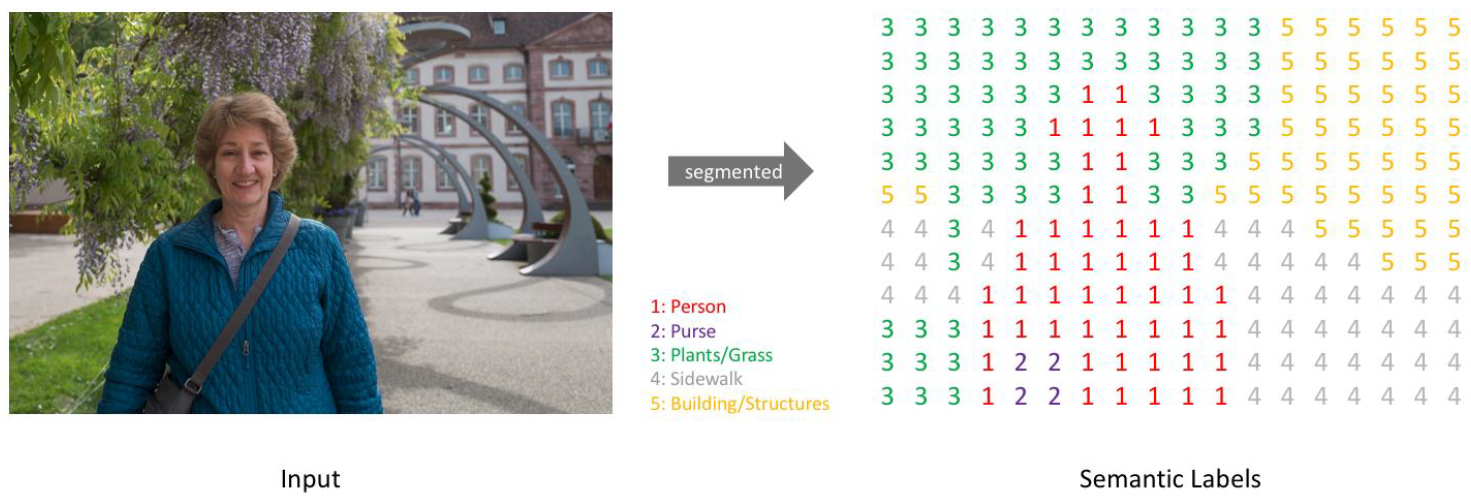

---

传统的图像分类任务：因为网络最后有全连接层，即会有很大的信息丢失。故传统的图像分类任务仅能做到对整张图像进行一个类别的划分，无法做到对图像中每个像素点进行类别划分（稠密估计问题）。

图像语义分割：使用FCN全卷积神经网络，用卷积层和池化层代替传统的全连接层，尽量减少信息丢失使得网络可以适应像素级的稠密估计任务。

---

FCN网络结构：非常有自编码器的那种感觉！

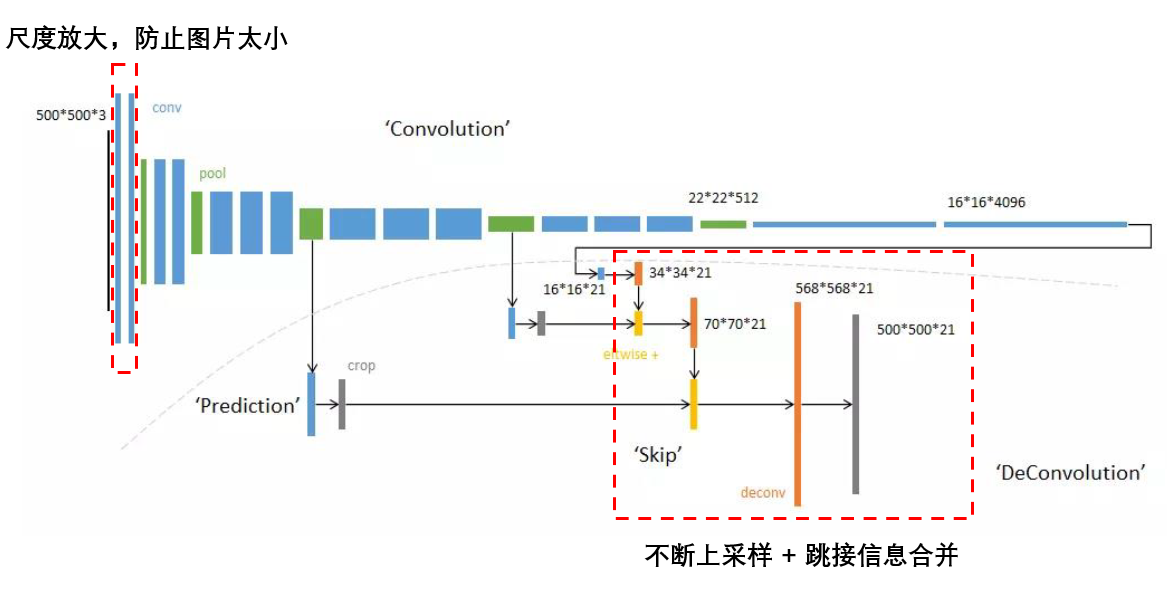

注意：
- 为什么可以输入任意尺寸的彩色图像：因为卷积层会自动对输入的图像进行拓展；卷积操作关心的空间特征，而因为尺寸不够在周围填充的内容都是同一种标签，所以不会影响判断。
- 输入：任意尺度图像；输出：与输入图像相同的尺度，通道数为：n（目标物种类） + 1（背景）

下采样/池化的方式：
- maxpool
- globalaveragepool
- 卷积时跨度大于1：strade > 1

上采样方式：将图像放大！
- 插值法
- 反池化：对应池化的两种反池化
- 反卷积（转置卷积）：纯把卷积操作反过来！通过训练得到：原来是训练从3x3=9个点获得1个点，现在是训练从1个点获得原来的9个点！

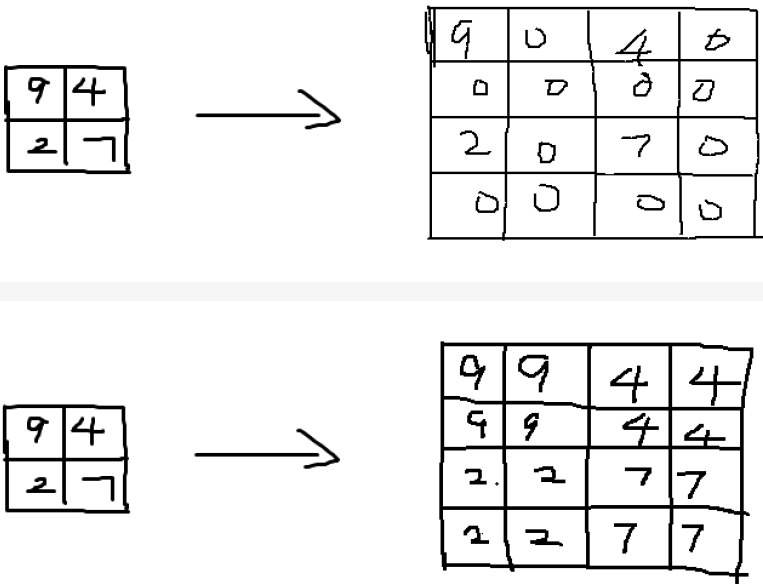

---

跳接结构说明：最开始卷积层都是提取大图内的“**局部细节**”信息，后面随着池化层的出现把图像不断变小，卷积层开始不断提取“**抽象全局**”信息！—— 跳接结构：既拿到网络最后的全局特征，又能拿到前面提取的局部特征，两大信息汇总才能实现对每个像素点的分类判断！—— 结合前面的特征（层）越多，对图像语义分割的**细节**越敏感！

缺点：
- 对细节刻画还是不够：对前面卷积层的细节信息汇聚还是不够！
- 没有考虑像素与像素之间的关系，缺乏空间一致性：绝大多数的像素和其周围，都是同一标签的！

In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt

In [2]:
# 查看一下标签图：只能用程序查看，用windows直接无法查看！
img_label_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\图片定位与分割数据集\annotations\trimaps\*' )
# 查看第一张：
img0_label = tf.io.read_file(img_label_path[0])
img0_label = tf.image.decode_png(img0_label)

In [3]:
print( len(img_label_path) )
img0.shape

7390


NameError: name 'img0' is not defined

In [ ]:
# 3通道时直接绘就行，1通道时把最后一维去掉即可！
img0_label = tf.squeeze( img0_label, -1 )
img0_label.shape

In [ ]:
plt.imshow(img0_label)

In [4]:
# 目标数据的标签：
np.unique( img0_label.numpy() )

array([1, 2, 3], dtype=uint8)

7390


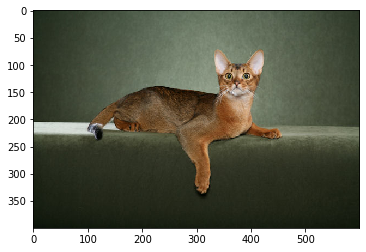

In [5]:
# 对应的原有图像：
img_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\图片定位与分割数据集\images\*' )
print( len(img_path) )

img0 = tf.io.read_file( img_path[0] )
img0 = tf.image.decode_png( img0 )
plt.imshow( img0 )

### 1. 加载所有图像、标签地址：

In [6]:
image_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\图片定位与分割数据集\images\*' )
label_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\图片定位与分割数据集\annotations\trimaps\*' )

In [7]:
# 抽查是否对应：
image_path[123:125],label_path[123:125]

(['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\images\\Abyssinian_228.jpg',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\images\\Abyssinian_230.jpg'],
 ['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\annotations\\trimaps\\Abyssinian_228.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\annotations\\trimaps\\Abyssinian_230.png'])

In [8]:
# 用相同规则进行乱序：
import random

np.random.seed(2019)
index = np.random.permutation( len(image_path) )

# 用相同的索引，进行乱序：
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]

In [9]:
# 再次抽查：
image_path[123:125],label_path[123:125]

(array(['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\images\\pug_139.jpg',
        'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\images\\Persian_175.jpg'],
       dtype='<U96'),
 array(['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\annotations\\trimaps\\pug_139.png',
        'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\图片定位与分割数据集\\annotations\\trimaps\\Persian_175.png'],
       dtype='<U109'))

### 2. 创建、划分数据集：

In [10]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [11]:
# 划分训练、测试集
test_count = int( len(image_path)*0.2 )
train_count = len(image_path) - test_count

train_dataset = dataset.skip(test_count)  # 跳过前这么多数据
test_dataset = dataset.take(test_count)   # 取前面这么多数据

In [12]:
train_dataset, test_dataset

(<SkipDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 文件预处理函数：解码、归一化、尺寸统一！

In [22]:
# 原图是jpg，标签图是png
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)  # 记得加通道，否则是None！
    return img

def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [23]:
# 预处理函数：
def normal_image(image, label):
    # 对原图的处理：转换数据类型 + 归一化[-1,1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1
    # 对标签图的处理：它的取值范围是[1,2,3]，但习惯于从0开始[0,1,2]！故都减去1
    label = label - 1
    return image, label

In [24]:
# 总加载函数：
new_height = 224
new_weight = 224

def load_image( image_path, label_path ):
    # 对原图的处理：
    image = read_jpg(image_path)
    image = tf.image.resize(image, (new_height, new_weight))
    # 对标签图的处理：
    label = read_png(label_path)
    label = tf.image.resize(label, (new_height, new_weight))
    
    return normal_image(image, label)

In [25]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_image, num_parallel_calls = AUTOTUNE )
test_dataset = test_dataset.map( load_image, num_parallel_calls = AUTOTUNE )  # 测试数据也要归一化！

In [26]:
# 查看最后的数据：
train_dataset, test_dataset

(<ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>,
 <ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>)

In [27]:
# 最后的乱序（让每个epoch的训练，看到的图像顺序不一样！）、batch划分：
BATCH_SIZE = 32  # 跟显存有关！
train_dataset = train_dataset.shuffle(train_count).repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


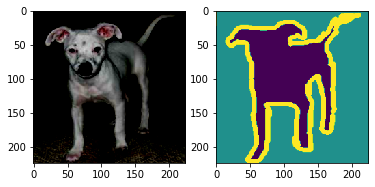

In [37]:
# 画图最后查看一下：从tf.data.Dataset拿出的数据，都是Tensor的！而matplotlib中的绘图必须是array的！
for image, label in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow( image[0].numpy() )
    plt.subplot(1,2,2)
    plt.imshow( label[0].numpy().reshape( (224,224) ) )

### 4. 使用预训练网络来搭建：获得多个中间层的输出！

In [38]:
conv_base = tf.keras.applications.VGG16( weights = 'imagenet', input_shape = (new_height, new_weight,3), include_top = False )

In [39]:
# 最简单的卷积-池化堆叠：
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

进行“**上采样**”和“**跳接**”的操作：
- **block5_pool** 的输出是7x7x512，对它进行反卷积，形成：14x14x512
- 获得的14x14x512的尺寸后，和 **block5_conv3** 的输出14x14x512进行合并（直接通道上相加），形成：14x14x512（元素对应相加）
- 获得的14x14x512进行反卷积，形成：28x28x512
- 获得的28x28x512的尺寸后，和 **block4_conv3** 的输出28x28x512进行合并，形成：28x28x512
- 获得的28x28x512进行反卷积，形成：56x56x512
- 获得的56x56x512的尺寸后，和 **block3_conv3** 的输出56x56x256进行合并，形成：56x56x256
- 获得的56x56x256进行反卷积，形成：112x112x256
- 获得的112x112x256的尺寸后，和 **block2_conv2** 的输出112x112x128进行合并，形成：112x112x128
- 获得的112x112x1904进行最后的反卷积，形成：224x224x3

需要提取出用来进行 “**跳接**” 的层：block5_pool、block5_conv3、block4_conv3、block3_conv3、block2_conv2！

---
获取中间层的方式：
- conv_base.layers[0:3]：用切片的方式获得中间层
- conv_base.get_layer('中间层名词')：用中间层名字来获取中间层（√）

获得**中间某层输出**的方式：每一层都有一个input、output属性！
- conv_base.layers[0].output
- conv_base.get_layer('中间层名字').output

总结，**每个层常用的3个属性有：.layers、.input、.output！**

In [46]:
# “中间某层输出”获取方式1：
conv_base.layers[0].output

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [45]:
# “中间某层输出”获取方式2：
conv_base.get_layer('block5_pool').output

<tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

In [47]:
conv_base.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [52]:
# 用一个“多输出网络”来汇聚所有的用来跳接的层：
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block2_conv2',
    'block5_pool'  # 最后的输出层out
]

# 把这些层名依次提取出来：
layers_output = [ conv_base.get_layer(layer_name).output for layer_name in layer_names ]

# 构建多输出网络：就是普通的多输出网络操作！
multi_out_model = tf.keras.models.Model(
    inputs = conv_base.input,
    outputs = layers_output
)

In [53]:
# 这些用来跳接的层，都是用已提取好的信息，即这些层是不可训练的！
multi_out_model.trainable = False

### 5. FCN搭建：

说明：整个网络结构可分为2个部分
- 前半部分：全是预训练好的VGG16模型（参数都不变），即特征提取部分相当于已经完成了！即整个网络的前半部分是不做任何修改的（不参与训练）！
- 后半部分：自定义的网络搭配，不断的“**反卷积 + 跳接**”形成新的层、新的输出；直到最后图片大小完全恢复！

注意：
- FCN搭建，主要就是对 “**后半部分**”的自定义搭建！整个模型需要训练的也就是FCN部分那些**反卷积的卷积核参数**（和前半部分一点关系都没）！
- 新加一个操作：每次**合并**之后，再用一次尺寸不变的卷积操作效果更好！
- 上采样时的**卷积核数量**，和即将要进行合并的之前的卷积层的输出中的**通道数一致**！

In [67]:
inputs = tf.keras.layers.Input( shape = (224,224,3) )

In [68]:
out_block5_conv3, out_block4_conv3, out_block3_conv3, out_block2_conv2, out = multi_out_model(inputs)
# 查看一下各自的形状：
out.shape, out_block5_conv3, out_block4_conv3, out_block3_conv3, out_block2_conv2

(TensorShape([None, 7, 7, 512]),
 <tf.Tensor 'model_5/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'model_5/Identity_1:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'model_5/Identity_2:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'model_5/Identity_3:0' shape=(None, 112, 112, 128) dtype=float32>)

In [69]:
# 1. 对out层进行上采样，形成(14,14,512)
x1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation = 'relu' )(out)
print( x1.shape )

# 再加一层卷积提取特征：
x1 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu')(x1)
print(x1)

(None, 14, 14, 512)
Tensor("conv2d_3/Identity:0", shape=(None, 14, 14, 512), dtype=float32)


In [70]:
# 2. 第一次跳接：x1和out_block5_conv3直接对应位置的元素的和
x2 = tf.add(x1, out_block5_conv3)
x2.shape

TensorShape([None, 14, 14, 512])

In [71]:
# 3. 对x2层进行上采样，形成(28,28,512)；然后和out_block4_conv3合并：
x3 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation='relu')(x2)
# 加一层卷积：
x3 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu')(x3)
# 把x3和out_block4_conv3合并
x4 = tf.add(x3, out_block4_conv3)
x4.shape

TensorShape([None, 28, 28, 512])

In [72]:
# 4. 对x4层进行上采样，形成(56,56,256)；然后和out_block3_conv3合并：
x5 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu')(x4)
# 加一层卷积：
x5 = tf.keras.layers.Conv2D(256, 3, strides=(1,1), padding='same', activation='relu')(x5)
# 把x5和out_block4_conv3合并
x6 = tf.add(x5, out_block3_conv3)
x6.shape

TensorShape([None, 56, 56, 256])

In [73]:
# 5. 对x6层进行上采样，形成(112,112,128)；然后和out_block2_conv2合并：
x7 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu')(x6)
# 加一层卷积：
x7 = tf.keras.layers.Conv2D(128, 3, strides=(1,1), padding='same', activation='relu')(x7)
# 把x5和out_block4_conv3合并
x8 = tf.add(x7, out_block2_conv2)
x8.shape

TensorShape([None, 112, 112, 128])

In [74]:
# 6 最后只用把x8层上采样，形成(224,224,3)即可：多分类，用softmax！
x9 = tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='softmax')(x8)
x9.shape

TensorShape([None, 224, 224, 3])

In [77]:
# 模型创建：
model = tf.keras.models.Model( inputs = inputs, outputs = x9 )
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 14, 14, 512) 14714688    input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_6 (Conv2DTrans (None, 14, 14, 512)  2359808     model[6][4]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 512)  2359808     conv2d_transpose_6[0][0]         
____________________________________________________________________________________________

In [78]:
# 模型编译：
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [79]:
# 模型训练：
epoches = 30
history = model.fit(
    train_dataset,
    epochs = epoches,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = test_dataset,
    validation_steps = test_count // BATCH_SIZE
)

Train for 184 steps, validate for 46 steps
Epoch 1/30
  1/184 [..............................] - ETA: 8:53:11

KeyboardInterrupt: 